In [1]:
# General Imports
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader,random_split, Dataset
from utils.fixes import global_seed
global_seed(42)
%matplotlib inline

Global seed set to 42


In [2]:
# chech GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
device = torch.device(device)
device

device(type='cuda')

In [10]:
smifile = "250k_rndm_zinc_drugs_clean_3.csv"
data = pd.read_csv(smifile, delimiter = ",")

In [11]:
data.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [12]:
len(data)

249455

In [13]:
charset = set("".join(list(data.smiles))+"?E")
#sort charset
charset = sorted(list(charset))
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
max_len = max([len(smile) for smile in data.smiles]) + 5

In [14]:
print(f'Charset: {charset}')
print(f'Embedding length: {max_len}')
print(f'Number of characters: {len(charset)}')

Charset: ['\n', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', '?', '@', 'B', 'C', 'E', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', '\\', ']', 'c', 'l', 'n', 'o', 'r', 's']
Embedding length: 115
Number of characters: 37


In [111]:
def vectorize(smiles):
    ''' Vectorize a list of SMILES strings to a numpy array of shape (len(smiles), embed, len(charset))'''
    X = np.zeros((len(smiles), max_len, len(charset)))
    for i, smile in enumerate(smiles):
        smile = '?'+ smile + 'E' * (max_len - len(smile) - 1)
        for j, char in enumerate(smile):
            X[i,j,char_to_int[char]] = 1
    return X

In [112]:
X_train = vectorize(data.smiles.values[:3])
X_train[0,:,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [113]:
def devectorize(X):
    ''' Devectorize a numpy array of shape (len(smiles), embed, len(charset)) to a list of SMILES strings'''
    smiles = []
    for i in range(X.shape[0]):
        smile = ""
        for j in range(X.shape[1]):
            smile += int_to_char[np.argmax(X[i,j,:])]
        smiles.append(smile)
    # Remove padding
    smiles = [smile.replace("?","").replace("E","") for smile in smiles]
    return smiles

In [114]:
devectorize(X_train)

['CC(C)N(C)CC1(CC(C(C)N)C(C)O1)C#C',
 'CCNCC1=C(CC)N(C(N)=O)C(NCC)=C1',
 'CC(C)CCOC1(C)OC(=O)C(CC=O)C1C']

In [115]:
class SMILESDataset(Dataset):
    def __init__(self, data, charset, max_len):
        self.data = data
        self.charset = charset
        self.max_len = max_len
        self.char_to_int = {c: i for i, c in enumerate(self.charset)}
        self.X = data.smiles

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X[idx]

    def vectorize(self, smiles):
        ''' Vectorize a list of SMILES strings to a numpy array of shape (len(smiles), embed, len(charset))'''
        X = np.zeros((len(smiles), self.max_len, len(self.charset)))
        for i, smile in enumerate(smiles):
            for j, char in enumerate(smile):
                X[i,j,self.char_to_int[char]] = 1
            X[i,j+1:,self.char_to_int["?"]] = 1
            X[i,j+2:,self.char_to_int["E"]] = 1
        return X

In [116]:
# Instantiate the dataset and dataloader objects
batch_size = 64
dataset = SMILESDataset(data, charset, max_len)
train_dataset, val_dataset, test_dataset = random_split(dataset, [int(0.8*len(dataset)), int(0.1*len(dataset)), int(0.1*len(dataset))])

In [117]:
dataset_2 = SMILESDataset(data, charset, max_len)
dataset.char_to_int["#"]

0

In [118]:
vectorize(dataset[0]).shape

(32, 55, 31)

In [119]:
input_size = len(charset)
hidden_size = input_size
num_layers = 2

In [120]:
# rewrite the model to use Encoder and Decoder classes
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, latent_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.linear_size = max_len * hidden_size
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.linear_size, latent_size * 2)
        self.fc2 = nn.Linear(latent_size * 2, latent_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        encoded, _ = self.encoder(x)
        encoded = self.flatten(encoded)
        encoded = self.dropout(self.relu(self.fc1(encoded)))
        encoded = self.fc2(encoded)
        return encoded
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, latent_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.linear_size = max_len * hidden_size
        self.fc1 = nn.Linear(latent_size, latent_size * 2)
        self.fc2 = nn.Linear(latent_size * 2, self.linear_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.decoder = nn.LSTM(hidden_size, output_size, num_layers, batch_first=True)

    def forward(self, x):
        decoded = self.dropout(self.relu(self.fc1(x)))
        decoded = self.fc2(decoded)
        decoded = decoded.view(-1, max_len, hidden_size)
        decoded, _ = self.decoder(decoded)
        return decoded

In [121]:
class Autoencoder_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, latent_size):
        super(Autoencoder_2, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers, latent_size)
        self.decoder = Decoder(hidden_size, input_size, num_layers, latent_size)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [122]:
model = Autoencoder_2(input_size, hidden_size, num_layers, latent_size=128)

In [123]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [124]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [125]:
history = {'train_loss': [], 'val_loss': []}

In [126]:
model_name = 'lin_test_3M_l128.pt'
# if os.path.exists(model_name):
#     model.load_state_dict(torch.load(model_name))
#     print("Loaded model from disk")
# else:
#     print("No model found, training from scratch")

In [127]:
model.to(device)

Autoencoder_2(
  (encoder): Encoder(
    (encoder): LSTM(31, 31, num_layers=2, batch_first=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=1705, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=128, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=1705, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (decoder): LSTM(31, 31, num_layers=2, batch_first=True)
  )
)

In [128]:
from IPython.core.display_functions import clear_output
i = 0
num_epochs = 10
best_val_loss = np.inf
# use appropriate device
model.to(device)
print("Training on {}".format(device))
for epoch in range(num_epochs):
    train_epoch_loss = 0
    val_epoch_loss = 0
    for batch in train_loader:
        model.train()
        optimizer.zero_grad()
        batch = vectorize(batch)
        batch = torch.FloatTensor(batch)
        batch = batch.to(device)
        outputs = model(batch)
        loss = criterion(outputs, batch)
        train_epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_epoch_loss /= len(train_loader)
    #------------------------------------------
    for batch in val_loader:
        model.eval()
        batch = vectorize(batch)
        batch = torch.FloatTensor(batch)
        batch = batch.to(device)
        outputs = model(batch)
        val_loss = criterion(outputs, batch)
        val_epoch_loss += val_loss.item()
    val_epoch_loss /= len(val_loader)
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), model_name)
    history['train_loss'].append(train_epoch_loss)
    history['val_loss'].append(val_epoch_loss)
    print('Epoch [{}/{}], Train Loss: {:.6f}, Val Loss: {:.6f}'.format(epoch+1, num_epochs, train_epoch_loss, val_epoch_loss))
    if i > 5:
        clear_output(wait=True)
        i = 0
    else:
        i += 1

Epoch [8/10], Train Loss: 0.001026, Val Loss: 0.000272
Epoch [9/10], Train Loss: 0.001007, Val Loss: 0.000259
Epoch [10/10], Train Loss: 0.000995, Val Loss: 0.000254


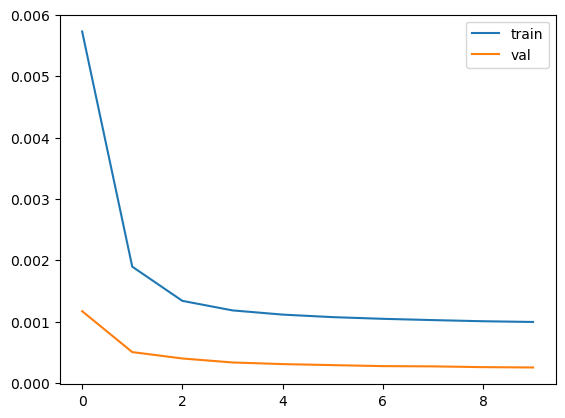

In [129]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.show()

In [134]:
# Test the model
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
n_test_batches = 20
with torch.no_grad():
    incorrect = 0
    for batch in test_loader:
        n_test_batches -= 1
        if n_test_batches < 0:
            break
        batch = vectorize(batch)
        batch = torch.FloatTensor(batch)
        batch = batch.to(device)
        outputs = model(batch)
        outputs = outputs.cpu().numpy()
        batch = batch.cpu().numpy()
        smiles = devectorize(batch)
        pred_smiles = devectorize(outputs)
        for i in range(len(smiles)):
            if smiles[i] != pred_smiles[i]:
                incorrect += 1
                print(f'Actual:    {smiles[i]}')
                # print difference in red color
                print('Predicted: ', end='')
                for j in range(len(smiles[i])):
                    try:
                        if smiles[i][j] != pred_smiles[i][j]:
                            print('\033[91m', end='')
                        print(pred_smiles[i][j], end='')
                        if smiles[i][j] != pred_smiles[i][j]:
                            print('\033[0m', end='')
                    except:
                        print('\nformat error')
                print('\n--------')

Actual:    ClC1=CC(=CC=C1)N1C(=O)SC(C=O)=CC1=N
Predicted: CCC1=CC(=CC=C1)N1C(=O)SC(C=O)=CC1=N
--------
Actual:    CC(=N)OC1=CC(OC=O)=C(Cl)C2=CC=CN12
Predicted: CC(=N)OC1=CC(OC=O)=C(CO)C2=CC=CN12
--------
Actual:    CCC(C)(C(C)N)C1=C2N=CN=C2ON=C1Cl
Predicted: CCC(C)(C(C)N)C1=C2N=CN=C2ON=C1CO
--------
Actual:    CC1=C2CC3CCC(CC(O)C#N)(O3)C2=NS1
Predicted: CC1=C2CC3CCC(CC(O)C#N)(O1)C2=NS1
--------
Actual:    CC1=CC(N)=C(C2=C(N)N=CS2)C(C=O)=C1F
Predicted: CC1=CC(N)=C(C2=C(N)N=CS2)C(C=O)=C12
--------
Actual:    CCN1CC2=C(C1)C1=C(S2)N=CC(Cl)=C1C#C
Predicted: CCN1CC2=C(C1)C1=C(S2)N=CC(C1)=C1C#C
--------
Actual:    CC(C)C(C)(N=C1OC(CO)=NC=C1F)C#N
Predicted: CC(C)C(C)(N=C1OC(CO)=NC=C12)C#N
--------
Actual:    CC(C(F)(F)F)C(C)(C)C1=C(COC1)C#N
Predicted: CC(C(C)(O)F)C(C)(C)C1=C(COC1)C#N
--------
Actual:    CCCOC1(C)CCC23CCCN2C(=N)NC13
Predicted: CCCOC1(C)CCC2OCCCN2C(=N)NC13
--------
Actual:    CC1CNC(C#C)C2=CC3CC=CCN3C12
Predicted: CC1CNC(C#C)C2=CC3CC=CCN1C12
--------
Actual:    CC1=NC(Br)=C2N=CO

In [135]:
print(f'Accuracy: {100*(1-incorrect/len(test_dataset)):.2f}%', end='')

Accuracy: 99.95%

In [136]:
# Test the model
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
with torch.no_grad():
    incorrect = 0
    for batch in test_loader:
        batch = vectorize(batch)
        batch = torch.FloatTensor(batch)
        batch = batch.to(device)
        outputs = model(batch)
        outputs = outputs.cpu().numpy()
        batch = batch.cpu().numpy()
        smiles = devectorize(batch)
        pred_smiles = devectorize(outputs)
        for i in range(len(smiles)):
            if smiles[i] != pred_smiles[i]:
                incorrect += 1

In [137]:
print(f'Accuracy: {100*(1-incorrect/len(test_dataset)):.2f}%', end='')

Accuracy: 88.08%

In [142]:
from torchviz import make_dot

In [194]:
x = torch.rand(1,55,31).to(device)
o = model(x)

In [197]:
make_dot(o, params=dict(model.named_parameters()))
#save png
from graphviz import Source
Source(make_dot(o, params=dict(model.named_parameters())).source).render('model.png', view=True)

'model.png.pdf'

In [143]:
def get_models(autoencoder, input_size, hidden_size, num_layers, latent_size):
    '''
    Returns the encoder and decoder with the same weights as the autoencoder
    '''
    encoder = Encoder(input_size, hidden_size, num_layers, latent_size)
    decoder = Decoder(hidden_size, input_size, num_layers, latent_size)
    encoder.load_state_dict(autoencoder.encoder.state_dict())
    decoder.load_state_dict(autoencoder.decoder.state_dict())
    return encoder, decoder

In [144]:
encoder, decoder = get_models(model, input_size, hidden_size, num_layers, latent_size=128)

In [145]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
def tanimoto_similarity(smiles1, smiles2):
    '''
    Returns the Tanimoto similarity between two SMILES strings
    '''
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
    return DataStructs.FingerprintSimilarity(fp1, fp2)


In [146]:
# Test the model
encoder.eval()
decoder.eval()
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [189]:
mdma = 'CC(NC)CC1=CC=C(OCO2)C2=C1'
propranolol = 'OC(COC1=C2C=CC=CC2=CC=C1)CNC(C)C'
aspirin = 'CC(=O)Oc1ccccc1C(=O)O'
x = vectorize([mdma])
encoded = encoder(torch.Tensor(x))

In [191]:
x.shape

(1, 55, 31)

In [148]:
decoded = decoder(encoded)
print(devectorize(decoded.detach().numpy())[0])

CC(NC)CC1=CC=C(OCO2)C2=C1


In [149]:
tanimoto_similarity(mdma, devectorize(decoded.detach().numpy())[0])

1.0

In [150]:
devectorize(decoded.detach().numpy())

['CC(NC)CC1=CC=C(OCO2)C2=C1']

In [151]:
sample = decoded.detach().numpy()[0]
sample

array([[ 5.0654035e-04,  3.2325453e-04,  9.5017673e-04, ...,
         1.4170870e-04, -2.6250142e-05, -3.6867257e-07],
       [-8.2879070e-14,  7.5429192e-09,  4.6130921e-13, ...,
         4.8811398e-07,  1.0231659e-03, -2.2854442e-04],
       [ 3.9277734e-06,  1.7996017e-05,  2.5138388e-11, ...,
        -2.3683272e-07,  1.3069469e-03, -3.7487047e-03],
       ...,
       [-4.2814168e-12,  1.2540774e-09, -1.9904946e-12, ...,
        -1.3947124e-05,  9.8004011e-06, -1.8087376e-04],
       [-3.3501858e-12,  5.2407395e-10, -1.9496605e-12, ...,
        -6.9840371e-06,  7.8485191e-06, -1.8772225e-04],
       [ 3.5905140e-12,  2.7202827e-09, -8.9910544e-12, ...,
        -1.0357403e-05,  1.2055729e-05, -1.6834280e-04]], dtype=float32)

In [152]:
idx = np.argmax(sample, axis=1)

In [153]:
''.join([int_to_char[i] for i in idx])

'?CC(NC)CC1=CC=C(OCO2)C2=C1EEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [154]:
print(int_to_char)

{0: '#', 1: '(', 2: ')', 3: '+', 4: '-', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '=', 13: '?', 14: 'B', 15: 'C', 16: 'E', 17: 'F', 18: 'H', 19: 'I', 20: 'N', 21: 'O', 22: 'S', 23: '[', 24: ']', 25: 'c', 26: 'l', 27: 'n', 28: 'o', 29: 'r', 30: 's'}


In [155]:
mdma = 'CC(NC)CC1=CC=C(OCO2)C2=C1'
propranolol = 'OC(COC1=C2C=CC=CC2=CC=C1)CNC(C)C'
x = vectorize([propranolol])
encoded = encoder(torch.Tensor(x))
decoded = decoder(encoded)
print(devectorize(decoded.detach().numpy())[0])
tanimoto_similarity(propranolol, devectorize(decoded.detach().numpy())[0])

CC1COC2=C3C=CC=CC2=CC=C1)CNC(C)C


[13:25:19] SMILES Parse Error: extra close parentheses while parsing: CC1COC2=C3C=CC=CC2=CC=C1)CNC(C)C
[13:25:19] SMILES Parse Error: Failed parsing SMILES 'CC1COC2=C3C=CC=CC2=CC=C1)CNC(C)C' for input: 'CC1COC2=C3C=CC=CC2=CC=C1)CNC(C)C'


ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

In [156]:
meth = 'C1=CC2=C(C=C1O)C(=CN2)CCN'
meth_vec = vectorize([meth])
meth_encoded = encoder(torch.Tensor(meth_vec))
meth_decoded = decoder(meth_encoded)

In [157]:
print(devectorize(meth_decoded.detach().numpy())[0])

CCNC12=C(C=C1O)C(=CN2)CCN


In [158]:
tanimoto_similarity(meth, devectorize(meth_decoded.detach().numpy())[0])

[13:25:23] Explicit valence for atom # 3 C, 5, is greater than permitted


ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

In [159]:
tanimoto_similarity(meth, mdma)

0.11320754716981132

In [160]:
# calculate distance between two vectors
from scipy.spatial.distance import cosine
cosine(meth_encoded.detach().numpy()[0], encoded.detach().numpy()[0])

1.2161215543746948

In [161]:
mdma_analog = 'CNC(CC1=CC=C2OC(C)OC2=C1)C(C)C'
mdma_analog_vec = vectorize([mdma_analog])
mdma_analog_encoded = encoder(torch.Tensor(mdma_analog_vec))
mdma_analog_decoded = decoder(mdma_analog_encoded)

In [162]:
print(devectorize(mdma_analog_decoded.detach().numpy())[0])

CCC(CC1=CC=C2OC(C)OC2=C1)C(C)C


In [163]:
tanimoto_similarity(mdma_analog, mdma)

0.4318181818181818

In [164]:
cosine(mdma_analog_encoded.detach().numpy()[0], encoded.detach().numpy()[0])

0.7898859232664108

In [165]:
import pubchempy as pcp

In [168]:
# get all amino acids
names = ['Alanine', 'Arginine', 'Asparagine', 'Aspartic acid', 'Cysteine', 'Glutamic acid', 'Glutamine', 'Glycine', 'Histidine', 'Isoleucine', 'Leucine', 'Lysine', 'Methionine', 'Phenylalanine', 'Proline', 'Serine', 'Threonine', 'Tryptophan', 'Tyrosine', 'Valine']
aa_smiles = []
for name in names:
    aa = pcp.get_compounds(name, 'name')
    print(name, aa[0].canonical_smiles)
    aa_smiles.append(aa[0].canonical_smiles)

Alanine CC(C(=O)O)N
Arginine C(CC(C(=O)O)N)CN=C(N)N
Asparagine C(C(C(=O)O)N)C(=O)N
Aspartic acid C(C(C(=O)O)N)C(=O)O
Cysteine C(C(C(=O)O)N)S
Glutamic acid C(CC(=O)O)C(C(=O)O)N
Glutamine C(CC(=O)N)C(C(=O)O)N
Glycine C(C(=O)O)N
Histidine C1=C(NC=N1)CC(C(=O)O)N
Isoleucine CCC(C)C(C(=O)O)N
Leucine CC(C)CC(C(=O)O)N
Lysine C(CCN)CC(C(=O)O)N
Methionine CSCCC(C(=O)O)N
Phenylalanine C1=CC=C(C=C1)CC(C(=O)O)N
Proline C1CC(NC1)C(=O)O
Serine C(C(C(=O)O)N)O
Threonine CC(C(C(=O)O)N)O
Tryptophan C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N
Tyrosine C1=CC(=CC=C1CC(C(=O)O)N)O
Valine CC(C)C(C(=O)O)N


In [169]:
len(aa_smiles)

20

In [170]:
aa_vec = vectorize(aa_smiles)
aa_encoded = encoder(torch.Tensor(aa_vec))

In [171]:
aa_encoded = aa_encoded.detach().numpy()

In [172]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vec_pca = pca.fit_transform(aa_encoded)

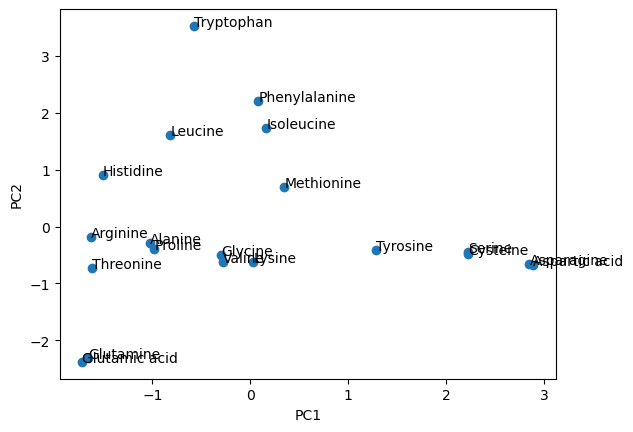

In [174]:
# plot PCA
import matplotlib.pyplot as plt
plt.scatter(vec_pca[:,0], vec_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
for i, txt in enumerate(names):
    plt.annotate(txt, (vec_pca[i,0], vec_pca[i,1]))

In [175]:
EM_accuracy = 0.0
for aa_smi, name in zip(aa_smiles, names):
    aa_vec = vectorize([aa_smi])
    aa_encoded_s = encoder(torch.Tensor(aa_vec))
    aa_decoded_s = decoder(aa_encoded_s)
    aa_decoded_smi = devectorize(aa_decoded_s.detach().numpy())[0]
    print(f'{name}: {aa_smi} -> {aa_decoded_smi}')
    if aa_smi == aa_decoded_smi:
        EM_accuracy += 1

print(EM_accuracy)

Alanine: CC(C(=O)O)N -> CC(C(=O)O)NC)=NNNN1N
Arginine: C(CC(C(=O)O)N)CN=C(N)N -> CCCC(C(=O)O)N)CN=C(N)N
Asparagine: C(C(C(=O)O)N)C(=O)N -> CCC(C(=O)C=N)C(=O)N1
Aspartic acid: C(C(C(=O)O)N)C(=O)O -> CCC(C(=O)C=N)C(=O)O
Cysteine: C(C(C(=O)O)N)S -> CCC(C(=O)C=N)SN=NN
Glutamic acid: C(CC(=O)O)C(C(=O)O)N -> CCCC(=O)O)C(C(=O)O)N
Glutamine: C(CC(=O)N)C(C(=O)O)N -> CCCC(=O)N=C(C(=O)O)N
Glycine: C(C(=O)O)N -> CCC(=O)O=NN=N)N1NN
Histidine: C1=C(NC=N1)CC(C(=O)O)N -> CCOC(NC=N1)CC(C(=O)O)N
Isoleucine: CCC(C)C(C(=O)O)N -> CCC(C)C(C(=O)O)N1=N
Leucine: CC(C)CC(C(=O)O)N -> CC(C)CC(C(=O)O)N1=N
Lysine: C(CCN)CC(C(=O)O)N -> CCCCN=CC(C(=O)O)N1)
Methionine: CSCCC(C(=O)O)N -> CCCC1(C(=O)O=NC=NN2
Phenylalanine: C1=CC=C(C=C1)CC(C(=O)O)N -> CCNC1=C(C=C1)CC(C(=O)C=N
Proline: C1CC(NC1)C(=O)O -> C1OC(NC1)C(=O)OC=NN
Serine: C(C(C(=O)O)N)O -> CCC(C(=O)C=N)OC=NN1
Threonine: CC(C(C(=O)O)N)O -> CC(C(C(=O)O)N=OC=NN
Tryptophan: C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N -> CCNC1=C2C(=C1)C(=CN2)CC(C(=O)C#N
Tyrosine: C1=CC(=CC=C1CC

In [185]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=15)
aa_encoded.shape

(20, 128)

In [186]:
vec_tsne = tsne.fit_transform(aa_encoded)

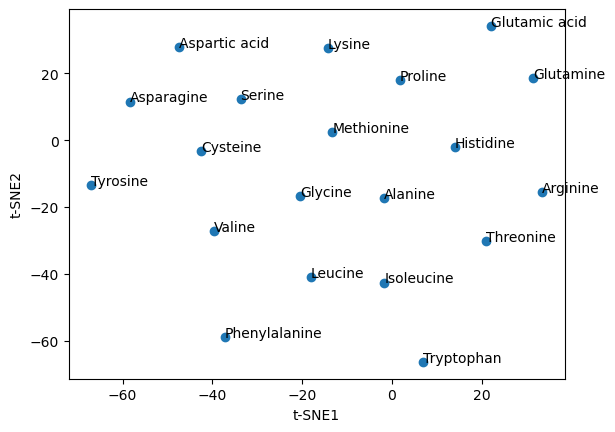

In [187]:
# plot t-SNE
import matplotlib.pyplot as plt
plt.scatter(vec_tsne[:,0], vec_tsne[:,1])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
for i, txt in enumerate(names):
    plt.annotate(txt, (vec_tsne[i,0], vec_tsne[i,1]))